<a href="https://colab.research.google.com/github/igorts-git/minesweeper-ai/blob/main/src/Minesweeper_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minesweeper solver using convolutions

### Minesweeper engine

The game logic is stored in a separate file `engine.py` on [GitHub](https://github.com/igorts-git/minesweeper-ai/)

In a separate module `ml_dataset.py` (also on GitHub) I put some helper clasess and functions for creating a dataset from randomly generated Minesweeper fields.

Each training sample is represented as a matrix of board height by width:
 * Input: each cell is an integer 0..8 represeting the number in that cell or 10 if the cell is hidden.
 * Labels: 1 if the cell has a mine in it, 0 if there is no mine, -100 if the cell is open. Note that -100 is a special value for `F.cross_entropy()` that tells it not to compute loss in that cell (because it's open already and its value is known via the input).

In [ ]:
!if [ ! -f "./engine.py" ]; then wget "https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/engine.py"; fi;
!if [ ! -f "./ml_dataset.py" ]; then wget "https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/ml_dataset.py"; fi;

--2024-06-17 19:33:20--  https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5415 (5.3K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   5.29K  --.-KB/s    in 0s      

2024-06-17 19:33:20 (79.3 MB/s) - ‘engine.py’ saved [5415/5415]

--2024-06-17 19:33:20--  https://raw.githubusercontent.com/igorts-git/minesweeper-ai/main/src/ml_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7855 (7.7K) [text/plain]
Saving t

In [33]:
import random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

from engine import MinesweeperEngine, CellValue, CELL_STR
import ml_dataset
%matplotlib inline

In [ ]:
# We will use GPU if it is available. Training will run several times faster on a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cuda'


### Generate the dataset

In [ ]:
# Training dataset
gen = ml_dataset.DatasetGenerator(width=64, height=64, num_samples_per_file=1000, save_dir="./data")
gen.GenerateDataset(num_files=4, override=False)

generated ./data/minesweeper_64x64_per_file_1000_file_idx_0.pt.gz in 21.70s
generated ./data/minesweeper_64x64_per_file_1000_file_idx_1.pt.gz in 22.39s
generated ./data/minesweeper_64x64_per_file_1000_file_idx_2.pt.gz in 19.24s
generated ./data/minesweeper_64x64_per_file_1000_file_idx_3.pt.gz in 18.58s


In [ ]:
# Test dataset
gen = ml_dataset.DatasetGenerator(width=128, height=128, num_samples_per_file=32, save_dir="./data")
gen.GenerateDataset(num_files=2, override=False)

generated ./data/minesweeper_128x128_per_file_32_file_idx_0.pt.gz in 2.55s
generated ./data/minesweeper_128x128_per_file_32_file_idx_1.pt.gz in 2.68s


In [ ]:
!du -sh ./data

7.2M	./data


### Build the model

In [ ]:
eng = MinesweeperEngine(width=10, height=12, num_mines=40)
eng.partially_open(open_ratio=0.2)
print(eng.to_str(is_view_mask=True))
print(f"{eng.is_game_over=} open_ratio={eng.open_ratio():.2f}")
print(ml_dataset.EngineToInputTensor(eng, device=device))
print(ml_dataset.EngineToLabelsTensor(eng, device=device))

1 ☒ ☒ ☒ ☒ 3 ☒ ☒ ☐ 2
☐ ☐ 5 ☐ ☐ ☐ ☒ ☒ ☒ ☒
☐ ☒ ☒ ☐ ☒ ☒ ☐ ☐ ☐ ☒
☒ ☐ 5 ☐ ☐ ☐ ☒ ☐ ☒ ☒
☐ ☒ ☒ ☒ ☐ ☐ ☐ 3 2 2
☒ ☐ ☒ ☐ ☐ ☐ ☒ 1    
☐ ☐ ☐ ☒ ☒ ☒ 2 1    
☐ ☐ ☒ ☐ ☒ ☐ 1      
☐ ☐ ☐ ☐ ☒ ☐ 1 2 3 2
☒ 2 ☐ ☒ 3 ☐ ☐ ☒ ☒ ☒
☐ ☐ ☒ ☒ 3 2 ☐ 3 ☐ ☐
☐ ☐ ☐ ☐ ☒ ☐ ☒ ☐ ☐ ☐
eng.is_game_over=False open_ratio=0.23
tensor([[ 1, 10, 10, 10, 10,  3, 10, 10, 10,  2],
        [10, 10,  5, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
        [10, 10,  5, 10, 10, 10, 10, 10, 10, 10],
        [10, 10, 10, 10, 10, 10, 10,  3,  2,  2],
        [10, 10, 10, 10, 10, 10, 10,  1,  0,  0],
        [10, 10, 10, 10, 10, 10,  2,  1,  0,  0],
        [10, 10, 10, 10, 10, 10,  1,  0,  0,  0],
        [10, 10, 10, 10, 10, 10,  1,  2,  3,  2],
        [10,  2, 10, 10,  3, 10, 10, 10, 10, 10],
        [10, 10, 10, 10,  3,  2, 10,  3, 10, 10],
        [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]], device='cuda:0')
tensor([[-100,    1,    1,    1,    1, -100,    1,    1,    0, -100],
        [   0,    0, -100,    0, 

In [ ]:
eval_dataset = ml_dataset.MinesweeperDataset(width=128, height=128, num_samples_per_file=32, data_dir="./data")
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=512, shuffle=False)
print(f"{len(eval_dataset)=}")
a, b = next(iter(eval_dataloader))
eval_data = (a.to(device), b.to(device))

len(eval_dataset)=512


In [ ]:
# We use shuffling built into the dataset reader, because it caches the whole file content in memory.
# Don't let the dataloader shuffle, because it will be prohibitevely slow.
train_dataset = ml_dataset.MinesweeperDataset(width=64, height=64, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"{len(train_dataset)=} {len(train_dataloader)=}")

len(train_dataset)=32000 len(train_dataloader)=1000


In [ ]:
VOCAB_SIZE = max(CellValue) + 1
HIDDEN_WIDTH = 64
OPT_LEARNING_RATE = 5e-4
OPT_WEIGHT_DECAY = 0.01
OPT_BETAS = (0.9, 0.99)
DROPOUT_RATE = 0.1

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, num_channels=HIDDEN_WIDTH, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=kernel_size, padding=padding)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.batch_norm = nn.BatchNorm2d(num_channels)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.dropout(input)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = x + input
        return x

class PlayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(VOCAB_SIZE, HIDDEN_WIDTH)
        self.conv_blocks = nn.Sequential(
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
        )
        self.top_conv = nn.Conv2d(in_channels=HIDDEN_WIDTH, out_channels=2, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor, targets: torch.Tensor | None = None, print_debug=False) -> torch.Tensor:
        dim = x.ndim
        if dim == 2:
            x = x.unsqueeze(0)

        if print_debug:
            print(f"input shape: {x.shape}")

        x = self.emb(x)
        if print_debug:
            print(f"after emb shape: {x.shape}")

        x = x.permute(0, 3, 1, 2)
        if print_debug:
            print(f"after permute shape: {x.shape}")

        x = self.conv_blocks(x)
        if print_debug:
            print(f"after conv_blocks shape: {x.shape}")

        x = self.top_conv(x)
        if print_debug:
            print(f"after top_conv shape: {x.shape}")

        logits = x
        loss = None
        if targets is not None:
            if targets.ndim == 2:
                targets = targets.unsqueeze(0)
            if print_debug:
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)
        if dim == 2:
            logits = logits.squeeze(0)
        return logits, loss

In [ ]:
with torch.no_grad():
    model = PlayerModel().to(device)
    num_params = sum((p.numel() for p in model.parameters()))
    print(f"Number of parameters: {num_params}")
    model.eval()
    X, Y = next(iter(train_dataloader))
    X = X.to(device)
    Y = Y.to(device)
    logits, loss = model(X, targets=Y, print_debug=True)
    print(f"{logits.shape=} {loss.shape=}")

Number of parameters: 223298
input shape: torch.Size([32, 64, 64])
after emb shape: torch.Size([32, 64, 64, 64])
after permute shape: torch.Size([32, 64, 64, 64])
after conv_blocks shape: torch.Size([32, 64, 64, 64])
after top_conv shape: torch.Size([32, 2, 64, 64])
targets shape: torch.Size([32, 64, 64])
logits.shape=torch.Size([32, 2, 64, 64]) loss.shape=torch.Size([])


In [ ]:
class Trainer:
    def __init__(self, model: nn.Module, eval_data: tuple[torch.Tensor, torch.Tensor]):
        self.model = model
        self.step_counter = 0
        self.lossi = []  # Loss at every training step
        self.restart_steps = []  # At which step we restarted training.
        self.eval_dataset = eval_data

    def do_train(self, num_steps, train_dataloader, learning_rate=OPT_LEARNING_RATE):
        self.model.train()
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=OPT_WEIGHT_DECAY, betas=OPT_BETAS, eps=1e-8)
        print_freq = num_steps // 15
        self.restart_steps.append(self.step_counter)
        train_iter = iter(train_dataloader)
        for i in range(num_steps):
            start_t = time.time()
            X, Y = next(train_iter)
            X = X.to(device)
            Y = Y.to(device)
            batch_t = time.time()
            optimizer.zero_grad()
            _, loss = self.model(X, targets=Y)
            loss.backward()
            optimizer.step()
            self.lossi.append(loss.log10().item())
            end_t = time.time()
            if i % print_freq == 0:
                step_time = end_t - start_t
                get_batch_time = batch_t - start_t
                get_batch_percent = 100.0 * get_batch_time / step_time
                with torch.no_grad():
                    self.model.eval()
                    X, Y = self.eval_dataset
                    _, eval_loss = self.model(X, targets=Y)
                    self.model.train()
                eval_time = time.time() - end_t
                print(f"{self.step_counter=} {step_time=:.2f} {get_batch_percent=:.1f}% {eval_time=:.2f} {loss.item()=:.4f} {eval_loss.item()=:.4f}")
            self.step_counter += 1

In [ ]:
trainer = Trainer(model, eval_data)

In [32]:
%%time
for _ in range(4):
    trainer.do_train(num_steps=len(train_dataloader), train_dataloader=train_dataloader, learning_rate=OPT_LEARNING_RATE)
    # Re-init the dataset to change the shuffle order
    train_dataset = ml_dataset.MinesweeperDataset(width=64, height=64, shuffle=True)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

self.step_counter=4000 step_time=1.01 get_batch_percent=90.3% eval_time=0.00 loss.item()=0.4372 eval_loss.item()=0.4594
self.step_counter=4066 step_time=0.08 get_batch_percent=7.3% eval_time=0.01 loss.item()=0.4259 eval_loss.item()=0.4435
self.step_counter=4132 step_time=0.08 get_batch_percent=4.0% eval_time=0.00 loss.item()=0.4431 eval_loss.item()=0.4416
self.step_counter=4198 step_time=0.08 get_batch_percent=5.9% eval_time=0.01 loss.item()=0.4731 eval_loss.item()=0.4412
self.step_counter=4264 step_time=0.08 get_batch_percent=3.8% eval_time=0.00 loss.item()=0.4440 eval_loss.item()=0.4410
self.step_counter=4330 step_time=0.08 get_batch_percent=3.9% eval_time=0.00 loss.item()=0.4547 eval_loss.item()=0.4425
self.step_counter=4396 step_time=0.08 get_batch_percent=4.0% eval_time=0.00 loss.item()=0.4369 eval_loss.item()=0.4409
self.step_counter=4462 step_time=0.08 get_batch_percent=4.1% eval_time=0.00 loss.item()=0.4477 eval_loss.item()=0.4409
self.step_counter=4528 step_time=0.08 get_batch

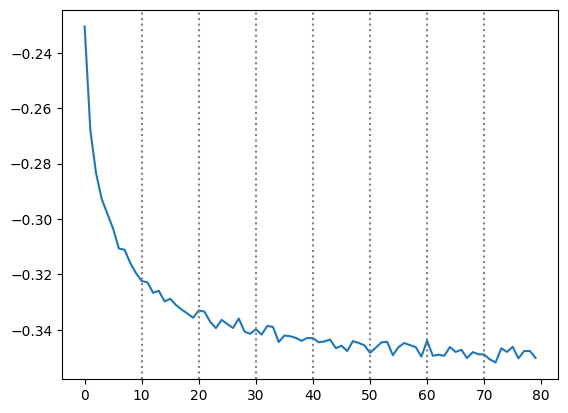

In [36]:
smooth_over_steps = 100
num_trim_losses = len(trainer.lossi) % smooth_over_steps
end_idx = len(trainer.lossi) - num_trim_losses
plt.plot(torch.tensor(trainer.lossi[:end_idx]).view(-1, smooth_over_steps).mean(1))
for x in trainer.restart_steps[1:]:
    plt.axvline(x//smooth_over_steps, linestyle=":", color="grey")

In [46]:
def show_game_probs(eng: MinesweeperEngine, props: torch.Tensor, colormap='binary', text_color='green', max_cell=None, ax: plt.Axes | None = None):
    image_and_text = [ax.imshow(props.cpu(), cmap=colormap)]
    for y in range(eng.height):
        for x in range(eng.width):
            if eng.view_mask[y][x] != CellValue.EMPTY:
                image_and_text.append(
                    ax.text(x, y, CELL_STR[eng.view_mask[y][x]], ha="center", va="center", color=text_color))
            if max_cell is not None and (x, y) == max_cell:
                image_and_text.append(
                    ax.text(x, y, "*", ha="center", va="center", color=text_color))
    #plt.show()
    return image_and_text

In [47]:
def generate_move(model: nn.Module, eng: MinesweeperEngine, ax: plt.Axes | None=None) -> tuple[int, int, float]:
    with torch.no_grad():
        model.eval()
        tensor = ml_dataset.EngineToInputTensor(eng, device=device)
        logits, _ = model(tensor)
        probs = F.softmax(logits, dim=0)
        mask = ml_dataset.EngineToHiddenMask(eng, device=device).float()

        # mine_prob = probs[1, :, :] * mask
        # show_game_probs(eng, mine_prob, colormap='cool')

        probs = probs[0, :, :] * mask

        max_ind = torch.argmax(probs).item()
        x = max_ind % tensor.shape[1]
        y = max_ind // tensor.shape[1]

        return x, y, probs[y, x].item() * 100.0, show_game_probs(eng, probs, colormap='hot', max_cell=(x,y), ax=ax)

☐ ☐ ☒ ☐ ☒ ☐ 1 ☐ ☐ ☒
☐ 2 ☐ ☐ ☐ ☒ ☐ ☐ ☒ ☒
☒ ☐ ☐ ☐ 2 ☐ ☐ ☒ ☐ ☐
☒ ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐ ☒
☐ ☒ ☐ ☐ ☐ ☐ ☐ ☐ ☐ ☐
☒ ☒ ☐ ☐ ☐ ☒ ☐ ☐ ☐ ☐
3 ☒ ☐ ☐ ☐ 2 ☐ ☒ ☐ ☐
1 2 ☐ ☐ ☒ ☐ ☐ ☐ ☐ ☐
  2 ☒ ☐ ☐ ☒ ☐ ☒ ☒ ☐
  2 ☒ ☒ ☒ 4 ☒ ☐ ☐ ☒
  1 2 3 2 4 ☒ ☐ ☐ ☐
          2 ☒ ☐ ☒ ☐
move=1 x=2 y=7 prob=99.87
move=2 x=2 y=6 prob=99.61
move=3 x=3 y=6 prob=99.79
move=4 x=3 y=7 prob=99.72
move=5 x=3 y=8 prob=97.45
move=6 x=4 y=6 prob=98.64
move=7 x=2 y=5 prob=99.17
move=8 x=6 y=8 prob=93.50
move=9 x=1 y=4 prob=87.43
  1 * 2 * 2 1 1 3 *
1 2 1 2 2 * 2 2 * *
* 2 1 1 2 1 2 * 4 3
* 3 2 * 1   1 1 2 *
4 X 3 1 2 1 1   1 1
* * 3   1 * 2 1 1  
3 * 2 1 2 2 2 * 1  
1 2 2 2 * 2 3 3 3 1
  2 * 5 4 * 3 * * 2
  2 * * * 4 * 4 3 *
  1 2 3 2 4 * 4 2 2
          2 * 3 * 1


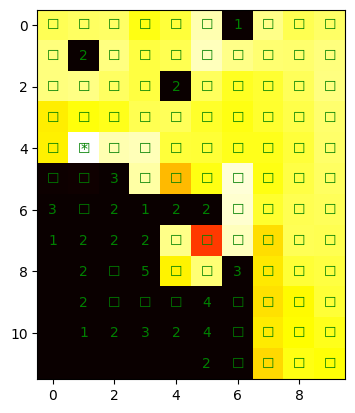

In [49]:
fig, ax = plt.subplots()
eng = MinesweeperEngine(width=10, height=12, num_mines=30)
eng.partially_open(open_ratio=0.2)
print(eng.to_str(is_view_mask=True))
move = 1
images = []
while not eng.is_game_over:
    x, y, prob, img = generate_move(model, eng, ax=ax)
    images.append(img)
    print(f"{move=} {x=} {y=} {prob=:.2f}")
    eng.open_cell(x, y)
    move += 1
print(eng.to_str(is_view_mask=True))
ani = animation.ArtistAnimation(fig=fig, artists=images, interval=500, blit=True, repeat_delay=1000)
ani.save('animation.gif', writer='pillow', fps=4)
Image('animation.gif')